In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz
import pystan
from scipy import sparse, stats
from typing import Iterable, Union, Callable
from sklearn.model_selection import train_test_split
import altair as alt

# Own files
import utils 

# Load and preprocess data

The data we have is essentially a matrix, where the each row correspond to a person, and each column correspond to a movie. However, the matrix is very sparse and thus data is stored in sparse format (i.e. specified with indices and the corresponding values). 

In [2]:
# Define constants

DATA_DIR = 'ml-100k'
SM_NORMALNORMAL_NAME = 'sm_normalnormal.stan'

In [3]:
from importlib import reload
reload(utils)

df, _, _ = utils.get_ml100k_data(DATA_DIR, subsample_top_users=150, subsample_top_items=20)

# We are not going to use timestamp, therefore drop it
df.drop('timestamp', axis='columns', inplace=True)

The user ids and item (movie) ids are essentially integer ranges, starting from and 1 to the number of users and items respectively. We don't have the all the unique ids when subsampling users and movies. It becomes problematic ... TODO: Write this

In [4]:
def column_relabler(df: pd.DataFrame, column: str):
    uniques = pd.value_counts(df[column], sort=False).index.values
    n_uniques = len(uniques)

    # Count from 1 to conform with Stan (Stan counts indexes arrays starting at 1)
    num2id = {num_:id_ for num_, id_ in zip(range(1, n_uniques+1), uniques)}
    id2num = {id_:num_ for num_, id_ in zip(range(1, n_uniques+1), uniques)}
    
    df[column] = df[column].map(id2num)
    return id2num, num2id

df_num = df.copy()
user2num, num2user = column_relabler(df_num, 'user_id')
item2num, num2item = column_relabler(df_num, 'item_id')

# p, q represents shape of the matrix as if it was dense
p, q = len(user2num), len(item2num)

In [5]:
df_train, df_valtest = train_test_split(df_num, test_size=50)
df_val, df_test = train_test_split(df_valtest, test_size=25)
del df_valtest

In [6]:
X = df_train.values

# Matrix Factorization 
Want to factorize the dense matrix $X_{n\times m} \approx U_{n\times k}V_{k\times m}$, where the subscripts denotes matrix shapes. The $k$ dimension denotes the user specified embedding dimension. We use different probabilistic models for the components. 


## Model 1 
Ultra simple

$$ U_{ij} \sim N(\mu_u, \sigma_u) $$
$$ V_{ij} \sim N(\mu_v, \sigma_v) $$
$$ X_{ij}\sim N((UV_{ij}), \sigma_x)$$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, \sigma_x$

## Model 2
Non-negative Matrix Factorization

$$ U \sim Gamma(\mu_u, \sigma_u) $$
$$ V \sim Gamma(\mu_v, \sigma_v) $$
$$ X_{ij}\sim Gamma(UV_{ij}, \sigma_x)$$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, \sigma_x$

## Model 3
ARD Model

$$ U \sim N(\mu_u, \alpha_u) $$
$$ V \sim N(\mu_v, \psi_v) $$
$$ X_{ij}\sim N((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a, b) $$

$$ \alpha_{ij} \sim Gamma(c, d) $$
$$ \psi_{ij} \sim Gamma(e, f) $$

User defined variables:
$a, b, c, d, e, f$

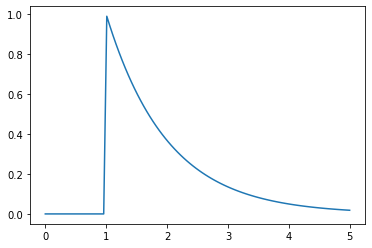

In [48]:
xrange = np.linspace(0,5,100)
plt.plot(xrange, stats.gamma.pdf(xrange, 1, 1))

In [18]:
sm_normalnormal_code = utils.get_stan_code(SM_NORMALNORMAL_NAME)
sm_normalnormal = utils.StanModel_cache(sm_normalnormal_code, 'normalnormal')

Using cached StanModel


In [8]:
%%time
data_normalnormal = dict(
    n_components = 10,
    n = X.shape[0],
    m = X.shape[1],
    p=p,
    q=q,
    X = X,
    mu_u = 1,
    sigma_u = 5,
    mu_v = 1,
    sigma_v = 5,
    sigma_x = 1
)

control = dict(
    max_treedepth=20
)

fit = sm_normalnormal.sampling(data_normalnormal, chains=1, n_jobs=-1, 
                               iter=4000, control=control, thin=5)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 3min 43s, sys: 594 ms, total: 3min 44s
Wall time: 3min 43s


In [9]:
Us, Vs = fit['U'], fit['V']

In [11]:
def ml100k_mae(df: pd.DataFrame, Us: np.ndarray, Vs: np.ndarray):
    # Xs is a 3D array
    Xs = Us@Vs
    
    # Offset with -1 because Stan index starts with 1
    row_inds = df.user_id-1
    col_inds = df.item_id-1
    ratings = df.rating.values
    
    y_preds = np.array([X[row_inds, col_inds] for X in Xs])
    errors = np.abs(y_preds - ratings)
    
    # Mean absolute error
    mae = errors.mean()
    
    return mae
    
print(ml100k_mae(df_train, Us, Vs))
print(ml100k_mae(df_val, Us, Vs))
print(ml100k_mae(df_test, Us, Vs))

0.6207983805594564
0.7622367208982618
0.8028536168470489


In [54]:
def CredibleIntervals(Us: np.ndarray, Vs: np.ndarray, scale: float=1, 
                      elements: int=20, n_samples: int=1000, p=0.95):
    # Xs is a 3D array
    Xs = Us@Vs
    row_inds, col_inds = np.unravel_index(range(elements), Xs.shape[1:])
    
    picks = np.random.randint(0, len(Xs), n_samples)
    P = Xs[picks][:,row_inds, col_inds]
    
    P = np.random.normal(loc=P, scale=scale, size=P.shape)
    P.sort(axis=0)
    
    half_p = (1-p)/2
    lb = np.floor((half_p*n_samples)).astype(int)
    ub = np.ceil((p+half_p)*n_samples).astype(int)
    
    return P[lb], P[ub]

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Test Place

In [ ]:
raise ValueError

In [ ]:
sm_test_code = utils.get_stan_code('sanity.stan')
sm_test = utils.StanModel_cache(sm_test_code, 'test')

In [ ]:
fit_test = sm_test.sampling(algorithm="Fixed_param", chains=4, n_jobs=-1, iter=10)

In [ ]:
A = np.array([[0.674531,0.560879],[-1.82799,0.0132566]])

In [ ]:
A@A

In [ ]:
X_ = 